# Mass accuracy distribution
All peaks are off by some amount. We want to be able to catch it even when the mass is off slightly. In order to test it accurately, we must first find how much they are off

We have both (1) the results of a search and (2) the raw spectrum. We can calculate all of the theoretical spectra that we know we should have, then iterate through our spectra and find out the perturbations

In [1]:
import pandas as pd
# LOAD THE RESULTS FILE
resfile = '/Users/zacharymcgrath/Downloads/NOD2_E3_results.ssv'
df = pd.read_csv(resfile, sep=';')



In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.spectra import gen_spectra



In [3]:
# create all the theoretical spectra
theoretical_spectra_doubly = []
theoretical_spectra_singly = []

for idx, row in df.iterrows():
    seq = row['sequence']
    theoretical_spectra_doubly.append(gen_spectra.gen_spectrum(seq, charge=2)['spectrum'])
    theoretical_spectra_singly.append(gen_spectra.gen_spectrum(seq, charge=1)['spectrum'])
    
    

## match them up or try to 
Here's the method:
1. for all real spectra
    1. take some top x peaks from a real spectrum
    2. calculate a distance that spectra is from all theoretical spectra
    3. Use the mininum distance theoretical spectrum as what we believe to be the theoretical spectra for that entry
    4. Find the minimum number of real peaks that explain most of the theoretical peaks
    5. For this number of these matched peaks, find how off they are from the theoretical peaks

In [4]:
def distance(spec1, spec2):
    dist = 0
    for spec in spec1:
        # find the min peak distance
        dist += min([abs(spec - s2) for s2 in spec2])
    return dist


In [5]:
def closest_peak(peak, spec):
    return min([abs(peak - p) for p in spec])

In [6]:
def filter_spectra(spec, x):
    labeled_abundance = [(i, a) for i, a in enumerate(spec['abundance'])]
    labeled_abundance.sort(key=lambda x: float(x[1]), reverse=True)
    labeled_abundance = labeled_abundance[:x]
    labeled_abundance.sort(key=lambda a: a[0])
    return [spec['spectrum'][x[0]] for x in labeled_abundance]
    

In [7]:
# load the spectra file
from src.file_io import mzML
specfile = '/Users/zacharymcgrath/Downloads/NOD2_E3.mzML'
spectra = mzML.read(specfile)


Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


In [8]:
top_peaks = 20
distdoubly = []
distsingly = []
limit = 5
for i, spec in enumerate(spectra):
    if i == limit:
        break
    print('on spec {}/{}\r'.format(i, len(spectra)), end='')
    # filter the spectra
    fsr = filter_spectra(spec, top_peaks)
    # find the closest spectra to this 
    closesttheoryd = None
    closesttheorys = None
    for theoryspecd in theoretical_spectra_doubly:
        if closesttheoryd is None:
            closesttheoryd = theoryspecd
        else:
            closesttheoryd = theoryspecd if distance(fsr, theoryspecd) < distance(fsr, closesttheoryd) else closesttheoryd
    for theoryspecs in theoretical_spectra_singly:
        if closesttheorys is None:
            closesttheorys = theoryspecs
        else:
            closesttheorys = theoryspecs if distance(fsr, theoryspecs) < distance(fsr, closesttheorys) else closesttheorys
            
    # ok now we have the closest spectra to each. Find the smallest distance for each peak
    for p in fsr:
        singlyd = closest_peak(p, closesttheorys)
        doublyd = closest_peak(p, closesttheoryd)
        if singlyd < doublyd:
            distsingly.append(singlyd)
        else:
            distdoubly.append(doublyd)    

            

In [9]:
import matplotlib.pyplot as plt
import numpy as np


Text(0, 0.5, 'count')

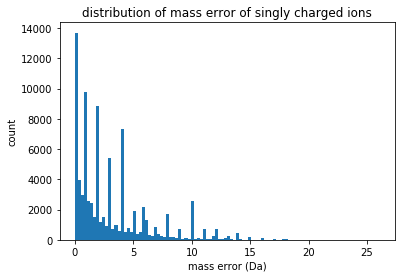

In [10]:
plt.hist(distsingly, bins=100)
plt.title('distribution of mass error of singly charged ions')
plt.xlabel('mass error (Da)')
plt.ylabel('count')


Text(0, 0.5, 'count')

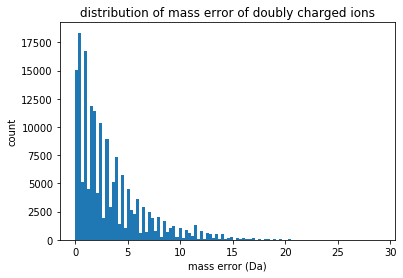

In [11]:
plt.hist(distdoubly, bins=100)
plt.title('distribution of mass error of doubly charged ions')
plt.xlabel('mass error (Da)')
plt.ylabel('count')


Text(0, 0.5, 'count')

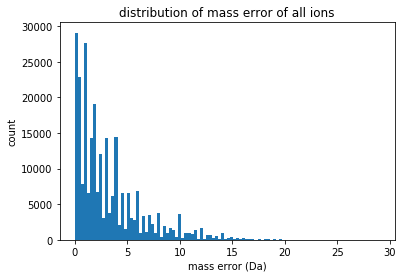

In [12]:
plt.hist(distdoubly + distsingly, bins=100)
plt.title('distribution of mass error of all ions')
plt.xlabel('mass error (Da)')
plt.ylabel('count')

Text(0, 0.5, 'count')

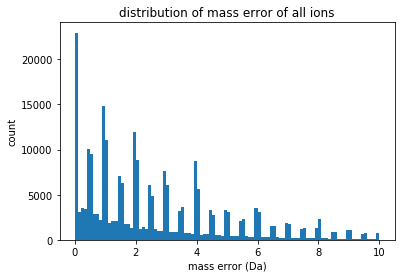

In [13]:
plt.hist(distdoubly + distsingly, bins=100, range=(0, 10))
plt.title('distribution of mass error of all ions')
plt.xlabel('mass error (Da)')
plt.ylabel('count')

## do individual ones

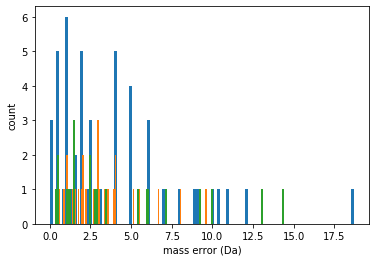

In [9]:
import matplotlib.pyplot as plt
import numpy as np
def plot_one(dist, label):
    plt.hist(dist, bins=100)
    plt.xlabel('mass error (Da)')
    plt.ylabel('count')
    plt.title(label)
    
for i in range(limit):
    start_range = i *25
    end_range = (i + 1) * 25
    plot_one(distsingly[start_range:end_range] + distdoubly[start_range:end_range], '')
    